I am testing using a neural network to recognise patterns in the pileup spectra, so that we can revert from a piled-up 1-D spectrum to the underlying 2-D spectrum. First I simulate pairs of piled, original spectra, then I make the network.

In [1]:
from importlib import reload
from utilities import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os


# Simulate spectra. 
Assume only multiplicity 2, and set the pileup probability to 1 for this test. 
Later we must check how an energy-dependent pileup probability affects things.

In [2]:
# Set some global variables:
N_events = int(30*1e3)
customLogNorm = LogNorm(vmin=1e0, vmax=N_events)
np.random.seed(124356)

In [3]:
# Import response matrix

fname_resp = 'resp-SuN2015-20keV-1p0FWHM.dat'
fname_resp_mat = 'response_matrix-SuN2015-20keV-1p0FWHM.m'
# fname_resp = 'resp-SuN2015-50keV-1p0FWHM.dat'
# fname_resp_mat = 'response_matrix-SuN2015-50keV-1p0FWHM.m'
R_2D, cal_resp, E_resp_array, tmp = read_mama_2D(fname_resp_mat)
# R_2D = div0(R_2D , R_2D.sum(rebin_axis=1))

# Read efficiency and other 1-D response variables:
resp = []
with open(fname_resp) as file:
    # Read line by line as there is crazyness in the file format
    lines = file.readlines()
    for i in range(4,len(lines)):
        try:
            row = np.array(lines[i].split(), dtype="double")
            resp.append(row)
        except:
            break

resp = np.array(resp)
# Name the columns for ease of reading
# FWHM = resp[:,1]
eff = resp[:,2]
# pf = resp[:,3]
# pc = resp[:,4]
# ps = resp[:,5]
# pd = resp[:,6]
# pa = resp[:,7]



Emax = 4000 # Crop response matrix (and thus also event generation) to efficiate computation
i_Emax = np.argmin(np.abs(E_resp_array-Emax))
R_2D = R_2D[0:i_Emax,0:i_Emax]
E_resp_array = E_resp_array[0:i_Emax]



# Assumed lower threshold for gammas in response matrix
E_thres = 100
i_thres = np.argmin(np.abs(E_resp_array - E_thres))
R_2D[:,:i_thres] = 0

for i in range(R_2D.shape[0]):
    norm = R_2D[i,:].sum()
    if(norm>0):
        R_2D[i,:] = R_2D[i,:] / norm #* eff[i]
    else:
        R_2D[i,:] = 0

In [4]:
# === Folding function for a single event ===
def FoldEg(Egs_t, Mf_max, Eg_arr, response, pileup=True, p_pile=0.2):
    """
    This function folds all Egs from a single event.
    """

    
    # print("Folding. True gammas =", Egs_t, flush=True)
    Mt_curr = len(Egs_t[Egs_t>0]) # Number of true gammas

    
    Mf_curr = Mt_curr # Folded multiplicity is the same as true because we do pileup after energy folding

    # Now proceed to fold each gamma with detector response:
    Egs_folded = np.zeros(Mf_curr)
    for i in range(Mf_curr):
        Eg = Egs_t[i]
        index_Eg = np.argmin(np.abs(Eg_arr - Eg))
        if R_2D[index_Eg,:].sum() > 0:
            # choosing rand accounts for the efficiency; As the efficiency read from file currently
            # does not always correspons with the counts in R_2D, see #3, we need two if tests
            rand = np.random.uniform()
            if rand <= eff[index_Eg]:
                # If the gamma is not lost to efficiency, redistribute its energy somewhere in the response:
                Eg_folded = np.random.choice(Eg_arr, p=response[index_Eg,:])
            else: 
                Eg_folded = 0 # Give Energy 0 to events that are not recorded.
        else: 
            Eg_folded = 0 # Give Energy 0 to events that are not recorded (below detector threshold)

        Egs_folded[i] = Eg_folded


    if pileup: # Is pileup desired?
        # For each folded gamma, assign it to pileup with probability p_pile:
        indices_pile = [] # Store indices in Egs_folded
        counter_nopile = 0
        map_to_pileup = {} # Map the indices that are *not* pileup to a new index set so that there are no index holes
                        # For example if Mt = 3 and index 1 is pileup, then map_nopile = {0:0, 2:1}.
                        # Then we decide which of the new indices to add each pileup event to.
        for i_t in range(Mt_curr):
            # Make sure at least one gamma is not assigned to pileup:
            if i_t == Mt_curr-1 and counter_nopile == 0:
                map_to_pileup[i_t] = counter_nopile
                counter_nopile += 1
                break

            # Also make sure no more than 4 gammas remain, by
            # setting pileup probability to 1 if we already have 4 non-piled
            if counter_nopile == 4:
                p_pile = 1

            r_pile = np.random.uniform()
            if r_pile < p_pile:
                # This gamma should be piled.
                indices_pile.append(i_t)
            else:
                # This gamma should not
                map_to_pileup[i_t] = counter_nopile
                counter_nopile += 1

        # Calculate multiplicity of current event after pileup:
        Mf_curr = Mt_curr - len(indices_pile)

        # Decide mapping of pileup gammas:
        for i_t in indices_pile:
            map_to_pileup[i_t] = np.random.randint(0,Mf_curr) if Mf_curr > 0 else 0

        Egs_piled = np.zeros(Mf_curr)
        for i_t in range(Mt_curr):
            Egs_piled[map_to_pileup[i_t]] += Egs_folded[i_t]

    else:
        # Do not include pileup:
        Egs_piled = Egs_folded
        # Mf_curr = Mt_curr

    # print("Piled gammas =", Egs_piled, flush=True)

    return Egs_piled

# Proof of principle, a single realization:
Generate true events and plot them:

In [7]:
Mt_max = 2 # Max true multiplicity 2
events_t = np.zeros((N_events,Mt_max))
N_centroids = 100 # How many different gaussian centroids to use for the gammas
Eg_gaussian_centroids = np.random.uniform(low=0, high=Emax/2, size=N_centroids)
for i_ev in range(N_events):
    # Mt_curr = np.random.randint(low=1,high=(Mt_max+1))
    Mt_curr = Mt_max # Testing, comparison to the first test we did with 2 gammas for the report
    # Egs_current = np.random.uniform(low=0, high=Emax, size=Mt_curr)
    Egs_current = np.random.normal(loc=[Eg_gaussian_centroids[np.random.randint(0,N_centroids)],Eg_gaussian_centroids[np.random.randint(0,N_centroids)]], scale=0.5*np.sqrt(Eg_gaussian_centroids[0:Mt_curr]), size=Mt_curr)
    events_t[i_ev,0:Mt_curr] = Egs_current   


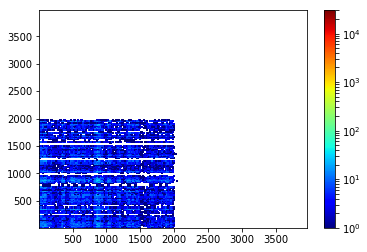

In [8]:
# == Sort and plot true events ==
E_t_array = E_resp_array
N_Eg = len(E_t_array)
counts_true = np.zeros((N_Eg, N_Eg))

# Sort data:
for i_ev in range(N_events):
    counts_true[np.argmin(np.abs(E_t_array-events_t[i_ev,0])),np.argmin(np.abs(E_t_array-events_t[i_ev,1]))] += 1

# Plot by Eg axes
cbar = plt.pcolormesh(E_t_array, E_t_array, counts_true, cmap="jet", norm=customLogNorm)
plt.colorbar(cbar)
plt.show()

In [9]:
# Simulate pileup
pileup = True
p_pile = 1
Mf_max = 1
events_f = np.zeros((N_events, Mf_max))
for i_ev in range(N_events):
    Egs_folded = FoldEg(events_t[i_ev,:], Mf_max=4, Eg_arr=E_resp_array, response=R_2D, pileup=pileup, p_pile=p_pile)
    events_f[i_ev,0:len(Egs_folded)] = Egs_folded

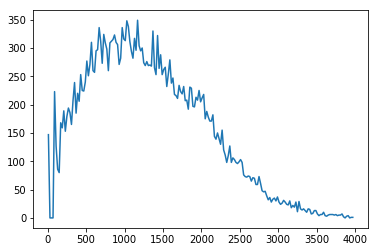

In [10]:
# Sort and plot piled events (1-D spectrum since p_pile = 1)
E_f_array = E_resp_array
N_Eg = len(E_f_array)
counts_folded = np.zeros((N_Eg))

# Sort data:
for i_ev in range(N_events):
    counts_folded[np.argmin(np.abs(E_f_array-events_f[i_ev,0]))] += 1

# Plot by Eg axes
cbar = plt.plot(E_t_array, counts_folded)
plt.show()

# It works, now generate an ensemble of spectra

In [12]:
# Generate true events:
N_ensemble = 200
N_events = int(30*1e3) # Events per ensemble
Mt_max = 2 # Max true multiplicity 2
purge_files = False # Regenerate simulations?

# Set calibration to use, should not be too large because of neural network
a0, a1 = 0, 100 # keV
N_nn = int(Emax/a1 - a0)


N_centroids = 100 # How many different gaussian centroids to use for the gammas

fname_ensemble_counts_true = "complex-ensemble_counts_true-"+str(N_ensemble)+"members.npy"
if os.path.exists(fname_ensemble_counts_true) and not purge_files:
    ensemble_counts_true = np.load(fname_ensemble_counts_true)
    ensemble_counts_true = ensemble_counts_true.reshape((N_ensemble, N_nn, N_nn))
else:
    E_nn_array = np.linspace(a0, a0+(N_nn-1)*a1, N_nn)

    memory_requirement = N_ensemble*N_events*Mt_max*8 / (1024)**2 # MB
    print("memory required to store event lists: {:.2f} MB".format(memory_requirement), flush=True)

    ensemble_list_true = []
    for i_ens in range(N_ensemble):
        events_t = np.zeros((N_events,Mt_max))
        # Draw gaussian centroids randomly up to half of the maximum response array energy
        Eg_gaussian_centroids = np.random.uniform(low=0, high=Emax/2, size=N_centroids)
        if i_ens % 10 == 0:
            print("Ensemble member {:d}".format(i_ens), flush=True)
        for i_ev in range(N_events):
            # Mt_curr = np.random.randint(low=1,high=(Mt_max+1))
            Mt_curr = Mt_max # Testing, comparison to the first test we did with 2 gammas for the report
            # Egs_current = np.random.uniform(low=0, high=Emax, size=Mt_curr)
            Egs_current = np.random.normal(loc=[Eg_gaussian_centroids[np.random.randint(0,N_centroids)],Eg_gaussian_centroids[np.random.randint(0,N_centroids)]], scale=0.5*np.sqrt(Eg_gaussian_centroids[0:Mt_curr]), size=Mt_curr)
            events_t[i_ev,0:Mt_curr] = Egs_current   
        ensemble_list_true.append(events_t)

    
    
    
    # Sort each ensemble member and plot a random member:
    E_t_array = E_resp_array
    N_Eg = len(E_t_array)

    # Sort data:
    #counts_true = np.zeros((N_nn, N_nn))
    ensemble_counts_true = np.zeros((N_ensemble, N_nn, N_nn))
    print("Sorting data", flush=True)
    for i_ens in range(N_ensemble):
        events_t = ensemble_list_true[i_ens]
        for i_ev in range(N_events):
            ensemble_counts_true[i_ens, np.argmin(np.abs(E_nn_array-events_t[i_ev,0])), np.argmin(np.abs(E_nn_array-events_t[i_ev,1]))] += 1

    np.save(fname_ensemble_counts_true, ensemble_counts_true)

memory required to store event lists: 91.55 MB
Ensemble member 0, Egs = 647.42, 1686.18
Ensemble member 10, Egs = 1495.82, 564.12
Ensemble member 20, Egs = 73.05, 150.76
Ensemble member 30, Egs = 657.15, 874.89
Ensemble member 40, Egs = 875.89, 1860.14
Ensemble member 50, Egs = 298.09, 1805.14
Ensemble member 60, Egs = 636.92, 10.45
Ensemble member 70, Egs = 1846.81, 1778.39
Ensemble member 80, Egs = 737.06, 1978.55
Ensemble member 90, Egs = 19.81, 752.96
Ensemble member 100, Egs = 248.58, 1236.25
Ensemble member 110, Egs = 341.13, 1334.31
Ensemble member 120, Egs = 1992.91, 1446.39
Ensemble member 130, Egs = 1566.34, 759.78
Ensemble member 140, Egs = 229.87, 824.20
Ensemble member 150, Egs = 791.96, 40.06
Ensemble member 160, Egs = 1265.08, 43.84
Ensemble member 170, Egs = 1277.73, 1468.56
Ensemble member 180, Egs = 898.50, 1452.07
Ensemble member 190, Egs = 1286.68, 855.36
Sorting data


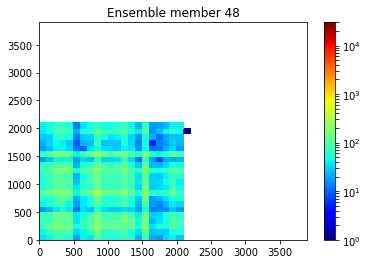

In [13]:
# Plot by Eg axes
index = np.random.randint(0,N_ensemble-1)
cbar = plt.pcolormesh(E_nn_array, E_nn_array, ensemble_counts_true[index,:,:], cmap="jet", norm=customLogNorm)
plt.colorbar(cbar)
plt.title("Ensemble member "+str(index))
plt.show()


Ensemble member 0
Ensemble member 10
Ensemble member 20
Ensemble member 30
Ensemble member 40
Ensemble member 50
Ensemble member 60
Ensemble member 70
Ensemble member 80
Ensemble member 90
Ensemble member 100
Ensemble member 110
Ensemble member 120
Ensemble member 130
Ensemble member 140
Ensemble member 150
Ensemble member 160
Ensemble member 170
Ensemble member 180
Ensemble member 190


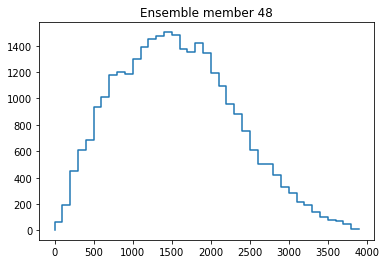

In [14]:
# Simulate pileup for each member:
pileup = True
p_pile = 1
Mf_max = 1

fname_ensemble_counts_folded = "complex-ensemble_counts_folded-"+str(N_ensemble)+"members.npy"
if os.path.exists(fname_ensemble_counts_folded) and not purge_files:
    ensemble_counts_folded = np.load(fname_ensemble_counts_folded)
    ensemble_counts_folded = ensemble_counts_folded.reshape((N_ensemble, N_nn))
else:
    ensemble_list_folded = []
    for i_ens in range(N_ensemble):
        if i_ens % 10 == 0:
            print("Ensemble member {:d}".format(i_ens), flush=True)
        events_f = np.zeros((N_events, Mf_max))
        for i_ev in range(N_events):
            Egs_folded = FoldEg(events_t[i_ev,:], Mf_max=4, Eg_arr=E_resp_array, response=R_2D, pileup=pileup, p_pile=p_pile)
            events_f[i_ev,0:len(Egs_folded)] = Egs_folded
        ensemble_list_folded.append(events_f)
    
    
    
    # Sort all ensemble members and plot same random member as above:
    ensemble_counts_folded = np.zeros((N_ensemble, N_nn))

    # Sort data:
    events_f = ensemble_list_folded[index]
    for i_ens in range(N_ensemble):
        for i_ev in range(N_events):
            ensemble_counts_folded[i_ens, np.argmin(np.abs(E_nn_array-events_f[i_ev,0]))] += 1

    # Plot by Eg axes
    plt.step(E_nn_array, ensemble_counts_folded[index,:])
    plt.title("Ensemble member "+str(index))
    plt.show()

    np.save(fname_ensemble_counts_folded, ensemble_counts_folded)

# Set up the neural network

I try to adapt something from the TensorFlow tutorial: 

train_in.shape = (200, 40)
train_out.shape = (200, 1600)


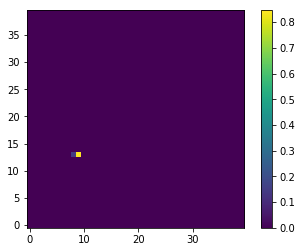

In [216]:
train_in = ensemble_counts_folded / ensemble_counts_folded.sum(axis=1).reshape((ensemble_counts_folded.shape[0],1))
print("train_in.shape =", train_in.shape)
train_out = ensemble_counts_true / ensemble_counts_true.sum(axis=(1,2)).reshape((ensemble_counts_folded.shape[0],1,1))
train_out = train_out.reshape(N_ensemble, int(N_nn**2))
print("train_out.shape =", train_out.shape)
plt.imshow(train_out[index].reshape(N_nn, N_nn), origin="lower")
plt.colorbar()

In [220]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(N_nn, activation=tf.nn.relu,
                       input_shape=(N_nn,)),
    keras.layers.Dense(int(N_nn**2), activation=tf.nn.relu),
    #keras.layers.Dense(int(N_nn**2)),
    keras.layers.Dense(int(N_nn**2))
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mae'])

In [221]:
# Train network
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 500
history = model.fit(train_in, train_out, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

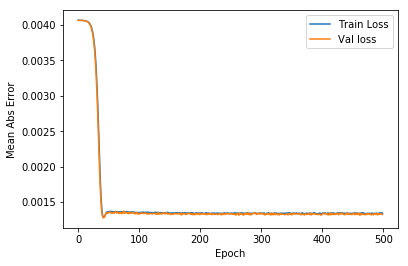

In [222]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  #plt.ylim([0, 5])

plot_history(history)

In [228]:
# Generate and check against new test data:
Mt_max = 2 # Max true multiplicity 2
events_t = np.zeros((N_events,Mt_max))
# Simulate pileup
pileup = True
p_pile = 1
Mf_max = 1


np.random.seed(1245)
N_test = 4


fname_ensemble_test_counts_true = "ensemble_test_counts_true-"+str(N_test)+"members.npy"
fname_ensemble_test_counts_folded = "ensemble_test_counts_folded-"+str(N_test)+"members.npy"
if os.path.exists(fname_ensemble_test_counts_true) and os.path.exists(fname_ensemble_test_counts_folded) and not purge_files:
    ensemble_test_counts_true = np.load(fname_ensemble_test_counts_true)
    ensemble_test_counts_true = ensemble_test_counts_true.reshape((N_test, N_nn, N_nn))
    ensemble_test_counts_folded = np.load(fname_ensemble_test_counts_folded)
    ensemble_test_counts_folded = ensemble_test_counts_true.reshape((N_test, N_nn))
else:
    ensemble_test_counts_true = np.zeros((N_test, N_nn, N_nn))
    ensemble_test_counts_folded = np.zeros((N_test, N_nn))
    for i_test in range(N_test):
        events_t = np.zeros((N_events, Mt_max))
        events_f = np.zeros((N_events, Mf_max))
    
        #Eg_gaussian_centroids = np.array([500,1700,1300,1000])
        Eg_gaussian_centroids = np.random.uniform(low=300,high=int(Emax/2),size=Mt_max)
        for i_ev in range(N_events):
            # Mt_curr = np.random.randint(low=1,high=(Mt_max+1))
            Mt_curr = Mt_max # Testing, comparison to the first test we did with 2 gammas for the report
            # Egs_current = np.random.uniform(low=0, high=Emax, size=Mt_curr)
            Egs_current = np.random.normal(loc=Eg_gaussian_centroids[0:Mt_curr], scale=0.5*np.sqrt(Eg_gaussian_centroids[0:Mt_curr]), size=Mt_curr)
            events_t[i_ev,0:Mt_curr] = Egs_current 
            Egs_folded = FoldEg(events_t[i_ev,:], Mf_max=4, Eg_arr=E_resp_array, response=R_2D, pileup=pileup, p_pile=p_pile)
            events_f[i_ev,0:len(Egs_folded)] = Egs_folded  

            # Sort:
            ensemble_test_counts_true[i_test, np.argmin(np.abs(E_nn_array-events_t[i_ev,0])), np.argmin(np.abs(E_nn_array-events_t[i_ev,1]))] += 1
            ensemble_test_counts_folded[i_test, np.argmin(np.abs(E_nn_array-events_f[i_ev,0]))] += 1
            
            
            
    np.save(fname_ensemble_test_counts_true, ensemble_test_counts_true)
    np.save(fname_ensemble_test_counts_folded, ensemble_test_counts_folded)
            
            
ensemble_test_counts_true /= ensemble_test_counts_true.sum(axis=(1,2)).reshape((ensemble_test_counts_folded.shape[0],1,1))
ensemble_test_counts_folded /= ensemble_test_counts_folded.sum(axis=1).reshape((ensemble_test_counts_folded.shape[0],1))

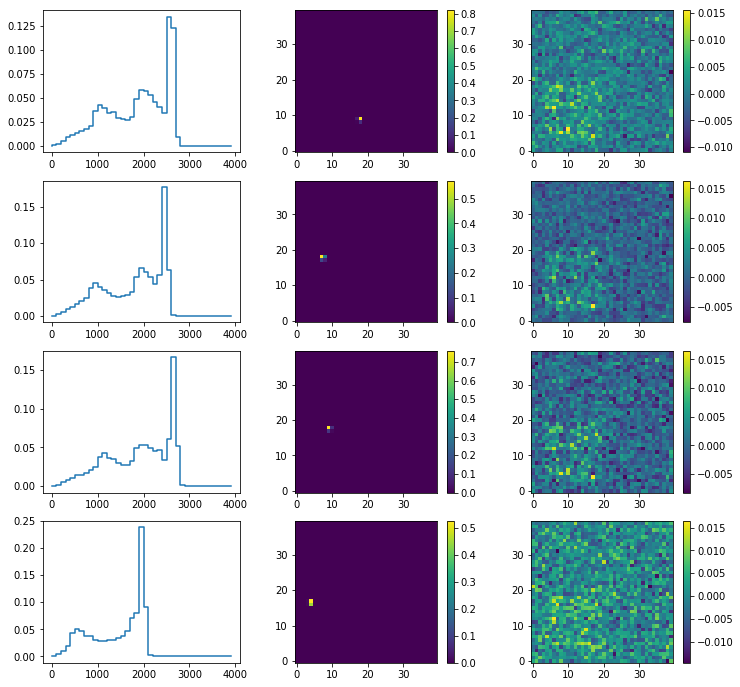

In [229]:
# Plot true and predicted
f, axs = plt.subplots(N_test,3)

for i_test in range(N_test):
    axs[i_test,0].step(E_nn_array, ensemble_test_counts_folded[i_test,:])
    cbar2 = axs[i_test,1].imshow(ensemble_test_counts_true[i_test,:,:], origin="lower")

    ensemble_test_counts_predicted = model.predict(ensemble_test_counts_folded)
    ensemble_test_counts_predicted = ensemble_test_counts_predicted.reshape((N_test, N_nn, N_nn))
    cbar3 = axs[i_test,2].imshow(ensemble_test_counts_predicted[i_test,:,:], origin="lower")
        
    ax1.set_title("Input folded spectrum")
    ax2.set_title("True spectrum")
    ax3.set_title("NN predicted spectrum")

    
    f.colorbar(cbar2, ax=axs[i_test,1])
    f.colorbar(cbar3, ax=axs[i_test,2])
f.set_size_inches(12,3*N_test)